# Baseline models training

Notebook contains training and validation of XGBoost models without any previous experiments on data.  We check 4 different prediction cases:
- All cancer types together, multiclass classification (stages: I, II, III, IV)
- All cancer types together, binary classification (stages: I-III vs IV)
- Only the most numerous types of cancer (each one separately), multiclass classification (stages: I, II, III, IV)
- Only the most numerous types of cancer (each one separately), binary classification (stages: I-III vs IV)

Outcomes can be treated as baseline results.

In [83]:
import os
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

Define random seed to allow reproducibility

In [84]:
random_state = 42
np.random.seed(random_state)

Load training data

In [85]:
data_path = '~/Documents/STUDIA/Projekt_badawczy/moje/TEPS_Data_preparation_data_sample_info/cleaned'

train = pd.read_csv(os.path.join(data_path, 'train.csv'), sep=';')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Columns: 191 entries, ID to ENSG00000271043
dtypes: float64(187), object(4)
memory usage: 838.7+ KB


### All cancer types together, multiclass classification (stages: I, II, III, IV)

Extract cancer types and stages to perform cross validation in a stratified way

Remove unnecessary columns: ID, Group, Sex and Age

In [86]:
X_train = train.copy(deep=True)

stratification_groups = X_train.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
X_train = X_train.loc[:, ~X_train.columns.isin(['ID','RealLocation', 'Group'])]

Encode labels

In [87]:
# labels_encoding_location = {
#     'VUMC': 0,
#     'MGH':  1,
#     'NKI':  2,
#     'Gron':  3,
#     'Gdansk': 4,
#     'AMC':  5,
#     'MAAS': 6,
#     'Pang': 7,
#     'Pisa': 8
# }
# X_train.loc[:, 'RealLocation'] = X_train['RealLocation'].map(labels_encoding_location)

# labels_encoding_group = {
#     'NSCLC': 0,
#     'Ovarian cancer':  1,
#     'Pancreatic cancer':  2,
#     'Cholangiocarcinoma':  3,
#     'Colorectal cancer': 4,
#     'Endometrial cancer':  5,
#     'Hepatocellular carcinoma': 6,
#     'Esophageal carcinoma': 7,
# }
# X_train.loc[:, 'Group'] = X_train['Group'].map(labels_encoding_group)

labels_encoding_sex = {
    'F': 0,
    'M': 1
}
X_train.loc[:, 'Sex'] = X_train['Sex'].map(labels_encoding_sex)

labels_encoding = {
    'I': 0,
    'II': 1,
    'III': 2,
    'IV': 3
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)

X_train['Stage'].value_counts()

3    348
2     84
1     81
0     49
Name: Stage, dtype: int64

In [88]:
# X_train['Group'].value_counts()

In [89]:
X_train.head(5)

,Sex,Age,Stage,ENSG00000010404,ENSG00000014216,ENSG00000025796,ENSG00000042753,ENSG00000044574,ENSG00000053254,ENSG00000062194,...,ENSG00000233614,ENSG00000236875,ENSG00000237805,ENSG00000237973,ENSG00000241468,ENSG00000243449,ENSG00000255633,ENSG00000255823,ENSG00000269028,ENSG00000271043
0,0,57.0,2,5.463555,9.760782,4.741108,6.942829,4.025145,4.097370,5.346144,...,6.748460,4.782774,4.320885,3.907697,3.907697,2.923800,3.776635,5.026179,6.664850,5.232786
1,1,63.0,3,4.440197,9.002281,6.661015,7.358500,5.751015,4.440197,7.166630,...,6.748099,5.245755,4.644626,4.054591,5.570080,5.872990,3.160626,4.196908,5.751015,4.196908
2,1,68.0,3,5.204413,10.472744,4.751953,6.689006,4.059333,4.482205,5.948256,...,7.686615,5.700639,4.596811,4.288587,4.976298,3.774516,3.877626,4.976298,6.818360,5.517021
3,1,82.0,3,6.115366,9.944259,5.186029,6.401231,6.065827,3.528759,5.725779,...,7.048001,5.693390,4.870013,3.325431,4.456606,3.053602,2.377126,2.377126,3.528759,3.053602
4,0,57.0,3,2.377126,8.675059,5.841736,6.633558,3.575373,3.575373,5.098731,...,6.488220,4.612638,4.612638,5.098731,4.828459,4.724905,4.029092,6.633558,8.240679,6.765517


Define functions for cross-validation in a stratified way: one for hyperparameters optimization (returns only mean score) and a second for validation of the model with best params (returns predictions)

In [90]:
def stratified_cross_val_score(
        estimator,
        df,
        stratification_groups,
        label_col,
        scoring,
        n_splits
):
    scores = np.zeros(n_splits)
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (train_index, test_index) in enumerate(skf.split(df, stratification_groups)):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])

        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)

        y_true = y.iloc[test_index]
        y_pred = estimator.predict(X.iloc[test_index])
        scores[i] = scoring(list(y_true), y_pred)

    return scores


def stratified_cross_val_predict(
        estimator,
        df,
        stratification_groups,
        label_col,
        n_splits=5
):
    y_pred = np.zeros(len(df))
    skf = StratifiedKFold(n_splits=n_splits)

    for train_index, test_index in skf.split(df, stratification_groups):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])

        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)
        y_pred[test_index] = estimator.predict(X.iloc[test_index])

    return y_pred

Define objective function for hyperparameters optimization using Optuna

In [91]:
def objective(trial: optuna.Trial, X_train, stratification_groups, xgb_config, scoring):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 6,12),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 0.4),
        **xgb_config
    }

    xgb = XGBClassifier(**params)

    scores = stratified_cross_val_score(
        estimator=xgb,
        df=X_train,
        stratification_groups=stratification_groups,
        label_col='Stage',
        scoring=scoring,
        n_splits=4
    )

    return scores.mean()

Since the classes are pretty imbalanced we use the weighted-average F1 metric for optimization

In [92]:
xgb_config = {
    'objective': 'multi:softmax',
    'random_state': random_state,
    'num_class': 4,
}

In [93]:

scoring_func = partial(f1_score, average='weighted')
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=scoring_func
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=10)

[I 2023-06-03 18:02:22,992] A new study created in memory with name: no-name-8f83a4f6-7b5b-4e2d-9dfa-1319471450ef
[I 2023-06-03 18:02:25,338] Trial 0 finished with value: 0.594748023839295 and parameters: {'n_estimators': 138, 'max_depth': 7, 'learning_rate': 0.09045003007326347, 'subsample': 0.8276946075209218, 'colsample_bytree': 0.9190500944476495, 'gamma': 0.207061717032803}. Best is trial 0 with value: 0.594748023839295.
[I 2023-06-03 18:02:27,795] Trial 1 finished with value: 0.5909768041904627 and parameters: {'n_estimators': 82, 'max_depth': 11, 'learning_rate': 0.004476604712421157, 'subsample': 0.9614955551899622, 'colsample_bytree': 0.8828180383698129, 'gamma': 0.005806003216072542}. Best is trial 0 with value: 0.594748023839295.
[I 2023-06-03 18:02:31,611] Trial 2 finished with value: 0.6012116015147108 and parameters: {'n_estimators': 175, 'max_depth': 10, 'learning_rate': 0.03342242950587245, 'subsample': 0.8763659597639977, 'colsample_bytree': 0.8810635193136191, 'gamma'

Extract the best of the found hyperparameters and perform cross validation on the whole training set

In [94]:
best_params = {
    # 70% (n_splits=5)
    #'n_estimators': 138, 'max_depth': 11, 'learning_rate': 0.0011767053011119924, 'subsample': 0.7397581181087902, 'colsample_bytree': 0.9715984571225978, 'gamma': 0.11395604621847816,
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=4
)
y_true = list(X_train['Stage'].values)

Define function for plotting confusion matrix

In [95]:
def plot_confusion_matrix(cm, labels, title):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', linewidths=1)
    plt.setp(plt.gca().get_xticklabels(), ha="right", rotation=45)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_title(title, y=-0.1, fontsize=20)

    fig.show()

In [96]:
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.60      0.59      0.60        49
          II       0.45      0.16      0.24        81
         III       0.32      0.10      0.15        84
          IV       0.72      0.95      0.82       348

    accuracy                           0.68       562
   macro avg       0.52      0.45      0.45       562
weighted avg       0.61      0.68      0.61       562



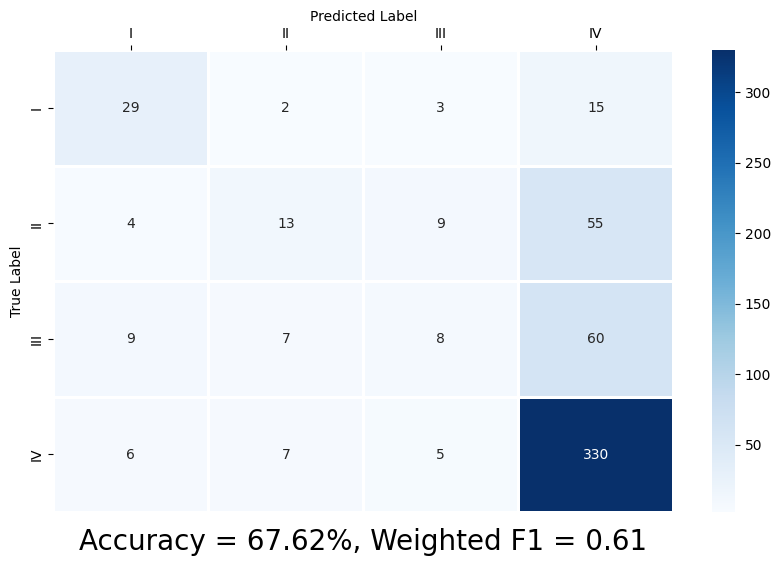

In [97]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'

plot_confusion_matrix(cm, labels, title)

## All cancer types together, binary classification (stages: I-III vs IV)

Map first three stages to one mutual class "I-III"

In [30]:
X_train = train.copy(deep=True)

mapping = {
    'I': 'I-III',
    'II': 'I-III',
    'III': 'I-III',
    'IV': 'IV'
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping)

In [31]:
stratification_groups = X_train.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
X_train = X_train.loc[:, ~train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

Encode labels

In [32]:
labels_encoding = {
    'I-III': 0,
    'IV': 1
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)

X_train['Stage'].value_counts()

1    372
0    268
Name: Stage, dtype: int64

Run hyperparameters optimization

In [34]:
xgb_config = {
    'objective': 'binary:logistic',
    'random_state': random_state
}

objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=f1_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-05-14 18:45:33,658] A new study created in memory with name: no-name-2f100f15-0d4b-482c-aafd-a1af4ad78656
[W 2023-05-14 18:45:33,684] Trial 0 failed with parameters: {'n_estimators': 106, 'max_depth': 3, 'learning_rate': 0.1182950220997281, 'subsample': 0.8878587875577402, 'colsample_bytree': 0.8553717222148176, 'gamma': 0.1275917887543393} because of the following error: ValueError('DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:RealLocation: object').
Traceback (most recent call last):
  File "/home/dariusz/anaconda3/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_16669/1724731852.py", line 14, in objective
    scores = stratified_cross_val_score(
  File "/tmp/ipykernel_16669/1455692053.py", line 16, in stratified_cross_val_score
    estimator

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:RealLocation: object

Extract the best of the found hyperparameters and perform cross validation on the whole training set

In [17]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)
y_true = list(X_train['Stage'].values)

In [18]:
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.75      0.59      0.66       268
          IV       0.74      0.86      0.80       372

    accuracy                           0.75       640
   macro avg       0.75      0.72      0.73       640
weighted avg       0.75      0.75      0.74       640



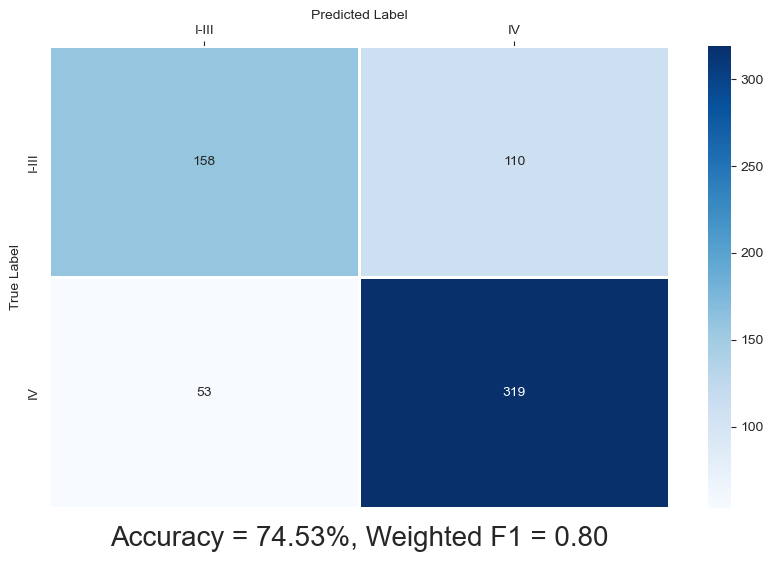

In [19]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'

plot_confusion_matrix(cm, labels, title)

## Only the most numerous types of cancer (each one separately), multiclass classification (stages: I, II, III, IV)

In [20]:
labels_encoding = {
    'I': 0,
    'II': 1,
    'III': 2,
    'IV': 3
}

xgb_config = {
    'objective': 'multi:softmax',
    'random_state': random_state,
    'num_class': 4,
}

scoring_func = partial(f1_score, average='weighted')

Get only the most numerous cancer types (with more than 90 cases)

In [23]:
cancer_type_counts = train['Group'].value_counts()
numerous_cancer_types = cancer_type_counts[cancer_type_counts > 90].index.tolist()
numerous_cancer_types

['NSCLC', 'Ovarian cancer', 'Pancreatic cancer']

For each cancer type a separate model will be created, optimized and tested

### NSCLC

In [24]:
X_train = train.loc[train['Group'] == 'NSCLC']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)
X_train['Stage'].value_counts()

3    247
2     34
0     11
1     10
Name: Stage, dtype: int64

In [25]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=scoring_func
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-04-16 20:11:10,182] A new study created in memory with name: no-name-3a398929-816b-43df-8340-d81a2d0cc2a8
[I 2023-04-16 20:11:30,709] Trial 0 finished with value: 0.7428083318097894 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.11696778549073497, 'subsample': 0.7565806006805513, 'colsample_bytree': 0.855117285359008, 'gamma': 0.25640702680069594}. Best is trial 0 with value: 0.7428083318097894.
[I 2023-04-16 20:11:47,705] Trial 1 finished with value: 0.7495328152526296 and parameters: {'n_estimators': 122, 'max_depth': 3, 'learning_rate': 0.08055347138726006, 'subsample': 0.6937521550187109, 'colsample_bytree': 0.7274121686289067, 'gamma': 0.7217360670664992}. Best is trial 1 with value: 0.7495328152526296.
[I 2023-04-16 20:12:07,625] Trial 2 finished with value: 0.7427705630735388 and parameters: {'n_estimators': 103, 'max_depth': 4, 'learning_rate': 0.0907965933162824, 'subsample': 0.7918952961992702, 'colsample_bytree': 0.9359472345071576, 'gamma':

In [26]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)
y_true = list(X_train['Stage'].values)

In [27]:
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.00      0.00      0.00        11
          II       0.00      0.00      0.00        10
         III       0.33      0.03      0.05        34
          IV       0.83      1.00      0.91       247

    accuracy                           0.82       302
   macro avg       0.29      0.26      0.24       302
weighted avg       0.72      0.82      0.75       302



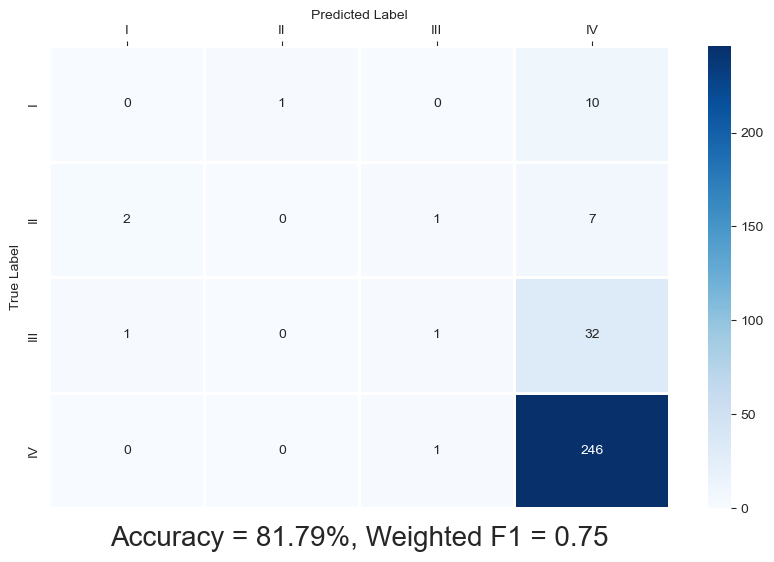

In [28]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'

plot_confusion_matrix(cm, labels, title)

### Ovarian cancer

In [29]:
X_train = train.loc[train['Group'] == 'Ovarian cancer']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)
X_train['Stage'].value_counts()

2    32
3    26
0    23
1    13
Name: Stage, dtype: int64

In [30]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=scoring_func
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-04-16 20:35:36,181] A new study created in memory with name: no-name-7bd9cf37-5b08-421e-87f3-ce99b71c52e0
[I 2023-04-16 20:35:44,305] Trial 0 finished with value: 0.3879024570940332 and parameters: {'n_estimators': 63, 'max_depth': 6, 'learning_rate': 0.02093005968199533, 'subsample': 0.996505674384168, 'colsample_bytree': 0.7614181161811826, 'gamma': 0.8334620632941301}. Best is trial 0 with value: 0.3879024570940332.
[I 2023-04-16 20:35:48,980] Trial 1 finished with value: 0.37445021388635513 and parameters: {'n_estimators': 42, 'max_depth': 2, 'learning_rate': 0.2513969382015448, 'subsample': 0.692488323177219, 'colsample_bytree': 0.8251055928369175, 'gamma': 0.6648984013295435}. Best is trial 0 with value: 0.3879024570940332.
[I 2023-04-16 20:36:02,471] Trial 2 finished with value: 0.37704686247306385 and parameters: {'n_estimators': 131, 'max_depth': 8, 'learning_rate': 0.13543629555601563, 'subsample': 0.7859602052720984, 'colsample_bytree': 0.851126418012295, 'gamma': 0.

In [31]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)
y_true = list(X_train['Stage'].values)

In [32]:
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.45      0.43      0.44        23
          II       0.00      0.00      0.00        13
         III       0.29      0.38      0.33        32
          IV       0.64      0.69      0.67        26

    accuracy                           0.43        94
   macro avg       0.35      0.38      0.36        94
weighted avg       0.39      0.43      0.41        94



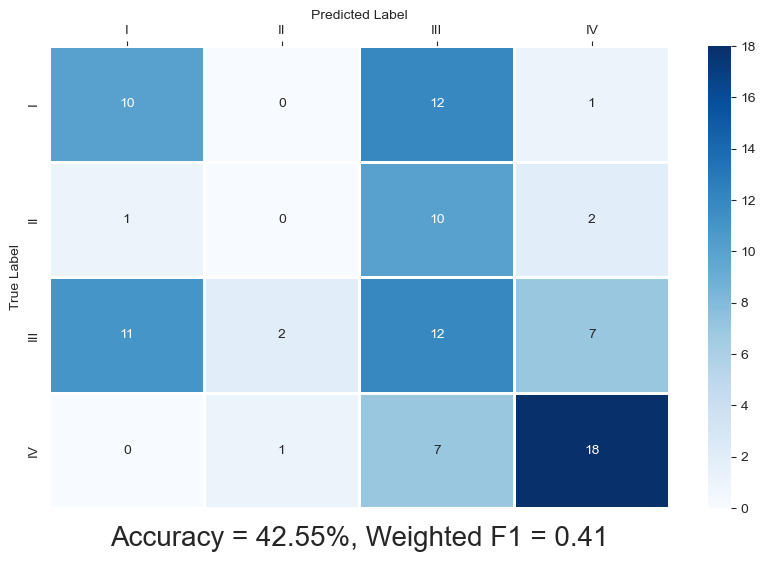

In [33]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'

plot_confusion_matrix(cm, labels, title)

### Pancreatic cancer


In [34]:
X_train = train.loc[train['Group'] == 'Pancreatic cancer']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)
X_train['Stage'].value_counts()

1    48
2    23
3    18
0     2
Name: Stage, dtype: int64

In [35]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=scoring_func
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-04-16 20:52:45,614] A new study created in memory with name: no-name-44cd3d11-f58a-4fea-8d5a-93b88bf290c9
[I 2023-04-16 20:52:51,398] Trial 0 finished with value: 0.3762408100395357 and parameters: {'n_estimators': 39, 'max_depth': 8, 'learning_rate': 0.011653336781692732, 'subsample': 0.9982370987594535, 'colsample_bytree': 0.8560338166557189, 'gamma': 0.36798649935684513}. Best is trial 0 with value: 0.3762408100395357.
[I 2023-04-16 20:53:03,874] Trial 1 finished with value: 0.4553364970217028 and parameters: {'n_estimators': 134, 'max_depth': 2, 'learning_rate': 0.14002692441583858, 'subsample': 0.9847932043895826, 'colsample_bytree': 0.8060796226412954, 'gamma': 0.37527875528346843}. Best is trial 1 with value: 0.4553364970217028.
[I 2023-04-16 20:53:18,320] Trial 2 finished with value: 0.4248089970166432 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.13703147770383006, 'subsample': 0.9286307009664274, 'colsample_bytree': 0.9313045356819333, 'gamm

In [36]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)
y_true = list(X_train['Stage'].values)

In [37]:
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.00      0.00      0.00         2
          II       0.53      0.81      0.64        48
         III       0.12      0.04      0.06        23
          IV       0.22      0.11      0.15        18

    accuracy                           0.46        91
   macro avg       0.22      0.24      0.21        91
weighted avg       0.35      0.46      0.38        91



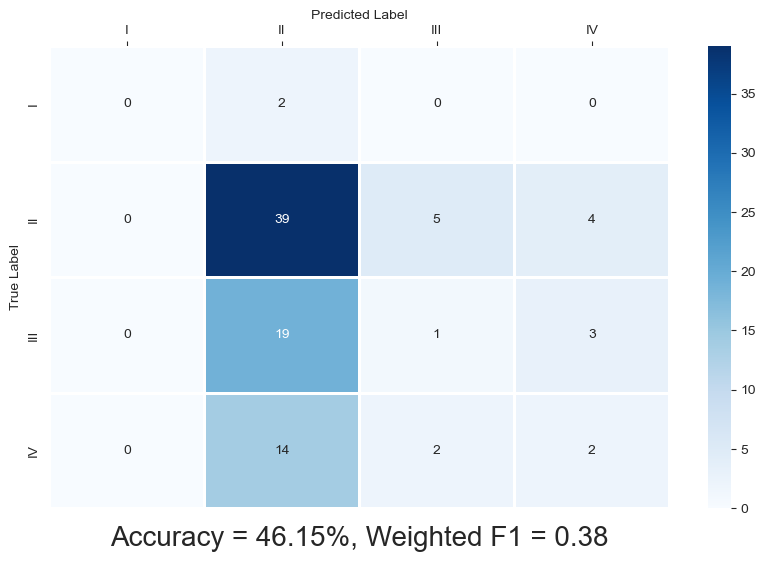

In [38]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = f'Accuracy = {accuracy*100:.2f}%, Weighted F1 = {f1:.2f}'

plot_confusion_matrix(cm, labels, title)

## Only the most numerous types of cancer (each one separately), binary classification (stages: I-III vs IV)

In [39]:
mapping = {
    'I': 'I-III',
    'II': 'I-III',
    'III': 'I-III',
    'IV': 'IV'
}

labels_encoding = {
    'I-III': 0,
    'IV': 1
}

xgb_config = {
    'objective': 'binary:logistic',
    'random_state': random_state
}

### NSCLC

In [40]:
X_train = train.loc[train['Group'] == 'NSCLC']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping).map(labels_encoding)
X_train['Stage'].value_counts()

1    247
0     55
Name: Stage, dtype: int64

In [41]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=f1_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-04-16 21:56:55,441] A new study created in memory with name: no-name-5b0d6b65-e2b4-4296-98e6-ca57ee3bdd86
[I 2023-04-16 21:56:59,257] Trial 0 finished with value: 0.92035670085987 and parameters: {'n_estimators': 35, 'max_depth': 2, 'learning_rate': 0.29509263455527723, 'subsample': 0.8874967018093747, 'colsample_bytree': 0.6195765410669845, 'gamma': 0.7204844067678828}. Best is trial 0 with value: 0.92035670085987.
[I 2023-04-16 21:57:09,050] Trial 1 finished with value: 0.9201179931646326 and parameters: {'n_estimators': 104, 'max_depth': 5, 'learning_rate': 0.21868704705931916, 'subsample': 0.7507189370756635, 'colsample_bytree': 0.8129720858061855, 'gamma': 0.3966923245013043}. Best is trial 0 with value: 0.92035670085987.
[I 2023-04-16 21:57:22,247] Trial 2 finished with value: 0.9134693718459301 and parameters: {'n_estimators': 142, 'max_depth': 8, 'learning_rate': 0.09854310030212783, 'subsample': 0.7020524663369129, 'colsample_bytree': 0.9219827957519978, 'gamma': 0.187

In [42]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)
y_true = list(X_train['Stage'].values)

In [43]:
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.78      0.25      0.38        55
          IV       0.86      0.98      0.92       247

    accuracy                           0.85       302
   macro avg       0.82      0.62      0.65       302
weighted avg       0.84      0.85      0.82       302



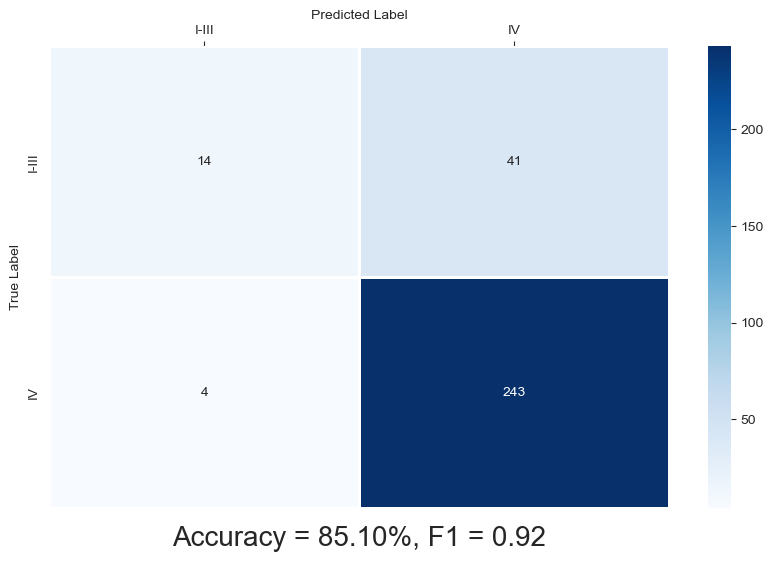

In [44]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'

plot_confusion_matrix(cm, labels, title)

### Ovarian cancer

In [45]:
X_train = train.loc[train['Group'] == 'Ovarian cancer']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping).map(labels_encoding)
X_train['Stage'].value_counts()

0    68
1    26
Name: Stage, dtype: int64

In [46]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=f1_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-04-16 22:13:12,520] A new study created in memory with name: no-name-b80667e9-b72e-4401-a07c-2d832825caf2
[I 2023-04-16 22:13:21,941] Trial 0 finished with value: 0.5799533799533799 and parameters: {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.2830542269322591, 'subsample': 0.6510870417595397, 'colsample_bytree': 0.614417899389999, 'gamma': 0.030714205476812917}. Best is trial 0 with value: 0.5799533799533799.
[I 2023-04-16 22:13:29,462] Trial 1 finished with value: 0.6089743589743589 and parameters: {'n_estimators': 95, 'max_depth': 7, 'learning_rate': 0.09769840726440591, 'subsample': 0.6361089908755416, 'colsample_bytree': 0.6207934759784575, 'gamma': 0.6794927040388267}. Best is trial 1 with value: 0.6089743589743589.
[I 2023-04-16 22:13:33,032] Trial 2 finished with value: 0.7522727272727272 and parameters: {'n_estimators': 30, 'max_depth': 5, 'learning_rate': 0.060616808707738674, 'subsample': 0.9623509179816955, 'colsample_bytree': 0.9041943069602576, 'gamma':

In [47]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)
y_true = list(X_train['Stage'].values)

In [48]:
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.90      0.97      0.94        68
          IV       0.90      0.73      0.81        26

    accuracy                           0.90        94
   macro avg       0.90      0.85      0.87        94
weighted avg       0.90      0.90      0.90        94



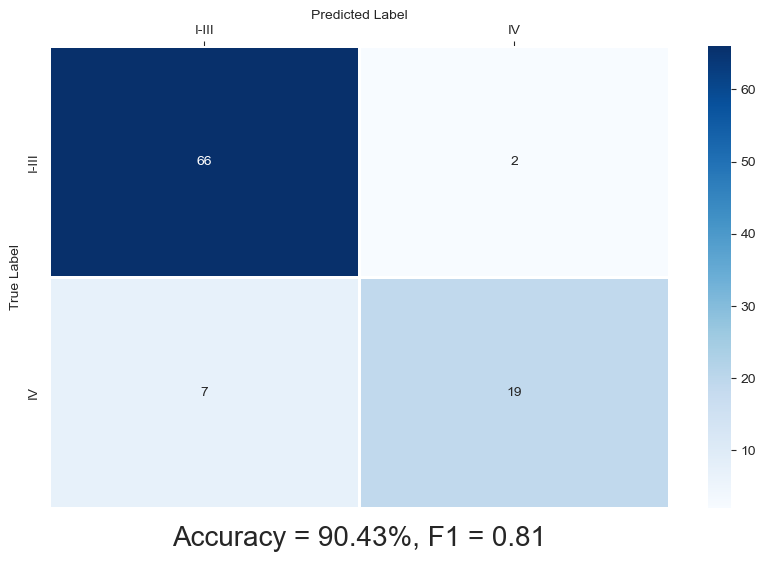

In [49]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'

plot_confusion_matrix(cm, labels, title)

### Pancreatic cancer

In [50]:
X_train = train.loc[train['Group'] == 'Pancreatic cancer']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping).map(labels_encoding)
X_train['Stage'].value_counts()

0    73
1    18
Name: Stage, dtype: int64

In [51]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=f1_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-04-16 22:50:01,469] A new study created in memory with name: no-name-70cac32b-6c7b-4750-ac67-5f1db1b5139f
[I 2023-04-16 22:50:09,083] Trial 0 finished with value: 0.07142857142857144 and parameters: {'n_estimators': 97, 'max_depth': 2, 'learning_rate': 0.14016985526795556, 'subsample': 0.6269967760941645, 'colsample_bytree': 0.9122848129931367, 'gamma': 0.7736655080470576}. Best is trial 0 with value: 0.07142857142857144.
[I 2023-04-16 22:50:18,648] Trial 1 finished with value: 0.19642857142857145 and parameters: {'n_estimators': 125, 'max_depth': 3, 'learning_rate': 0.23523040267297152, 'subsample': 0.6726789764665421, 'colsample_bytree': 0.6830021091277684, 'gamma': 0.9255540910515715}. Best is trial 1 with value: 0.19642857142857145.
[I 2023-04-16 22:50:24,854] Trial 2 finished with value: 0.08333333333333334 and parameters: {'n_estimators': 76, 'max_depth': 4, 'learning_rate': 0.09373965320718326, 'subsample': 0.6398994731007737, 'colsample_bytree': 0.9699101207432391, 'gam

In [52]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)
y_true = list(X_train['Stage'].values)

In [53]:
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.81      0.97      0.88        73
          IV       0.33      0.06      0.10        18

    accuracy                           0.79        91
   macro avg       0.57      0.51      0.49        91
weighted avg       0.71      0.79      0.73        91



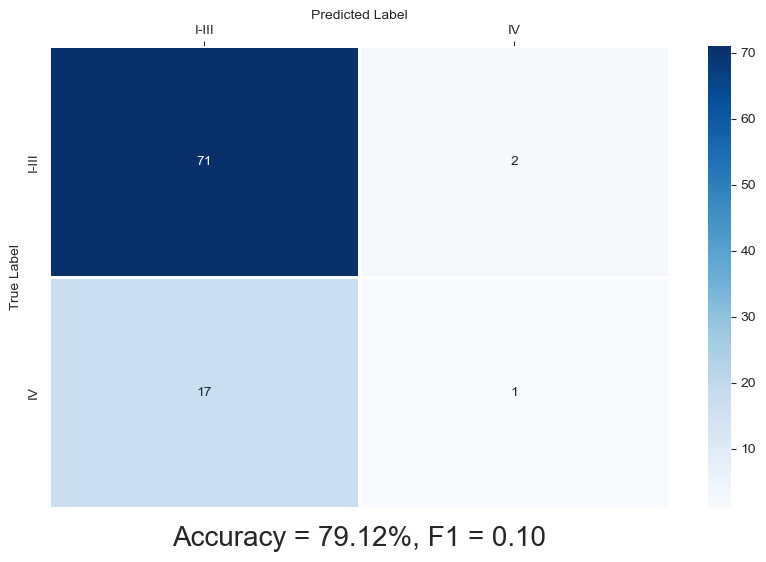

In [54]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = f'Accuracy = {accuracy*100:.2f}%, F1 = {f1:.2f}'

plot_confusion_matrix(cm, labels, title)